# Experiments on multiple toy ring data

In [1]:
%env CUDA_VISIBLE_DEVICES=4

%load_ext autoreload
%autoreload 2
import numpy as np
import umap
import matplotlib.pyplot as plt
import matplotlib
from scipy.sparse import coo_matrix
from umap.my_utils import compute_low_dim_psims, get_ring, filter_graph, kNN_dists
from umap.my_plot import hists_from_graph_embd, plot_all_losses
import os
import pickle


env: CUDA_VISIBLE_DEVICES=4


In [2]:
fig_path = "../figures"
data_path = "../data/toy_ring"

data_seed = 3
umap_seed = 0

radius = 4
sig = 0.5
sig_str = "_".join(str(sig).split("."))

# Multi rings

In [4]:
n_rings = [1, 2, 5, 10, 20]
n = 1000

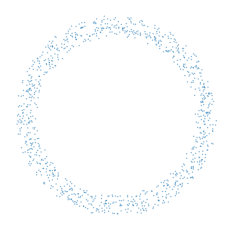

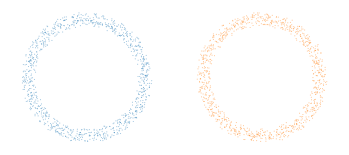

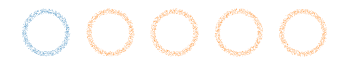

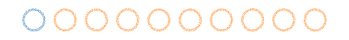

In [5]:
# get data
datasets_multi_ring = []
for k in n_rings:
    try:
        data_rings = np.load(os.path.join(data_path, f"toy_ring_multi_{k}_{n}_{radius}_{sig_str}_original_seed_{data_seed}.npy"))
    except FileNotFoundError:
        np.random.seed(data_seed)
        data_rings = []
        for i in range(k):
            data = get_ring(n, radius, sig, noise="uniform") + np.array([1, 0]) * i * radius * 3
            data_rings.append(data)
        data_rings = np.concatenate(data_rings)
        np.save(os.path.join(data_path,
                             f"toy_ring_multi_{k}_{n}_{radius}_{sig_str}_original_seed_{data_seed}.npy"),
                data_rings)
    datasets_multi_ring.append(data_rings)
    fig_data = plt.figure()
    plt.scatter(*data_rings[:1000].T,
                s=2/k,
                alpha = 0.5,
                edgecolors="none",
                linewidth=0)
    plt.scatter(*data_rings[1000:].T,
                s=2/k,
                alpha = 0.5,
                edgecolors="none",
                linewidth=0.0)

    plt.gca().set_aspect("equal")
    plt.axis('off')
    fig_data.savefig(os.path.join(fig_path, f"toy_multi_ring_{k}_{radius}_{sig_str}_original_seed_{data_seed}.png"),
                     bbox_inches = 'tight',
                     pad_inches = 0,
                     dpi=300)

In [8]:
# get umappers
umappers_multi_ring = []
for i, k in enumerate(n_rings):
    try:
        with open(os.path.join(data_path, f"umapperns_toy_ring_multi_{k}_{n}_init_10000_after_seed_{umap_seed}.pkl"), "rb") as file:
            umapper = pickle.load(file)
            umappers_multi_ring.append(umapper)
    except FileNotFoundError:
        umapper = umap.UMAP(random_state=umap_seed,
                              verbose=True,
                              n_epochs=10000,
                              init=datasets_multi_ring[i])
        umapper.fit(datasets_multi_ring[i])
        umappers_multi_ring.append(umapper)
        with open(os.path.join(data_path, f"umapperns_toy_ring_multi_{k}_{n}_init_10000_after_seed_{umap_seed}.pkl"), "wb") as file:
            pickle.dump(umapper, file, pickle.HIGHEST_PROTOCOL)

Wed Oct 20 19:59:40 2021 Building and compiling search function
Wed Oct 20 19:59:42 2021 Building and compiling search function
Wed Oct 20 19:59:46 2021 Building and compiling search function


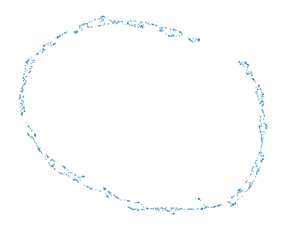

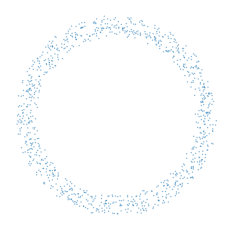

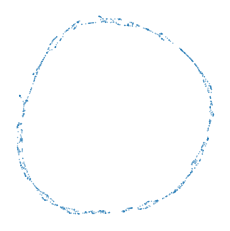

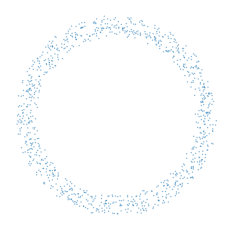

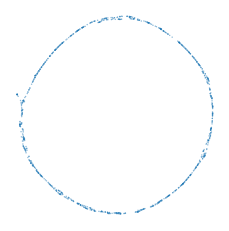

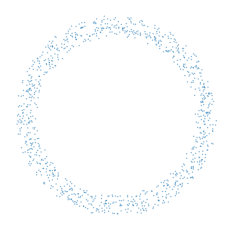

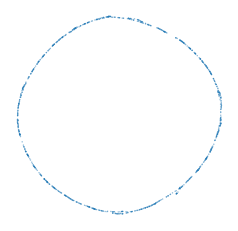

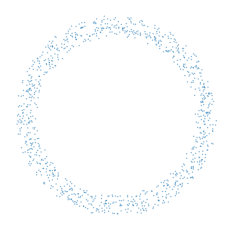

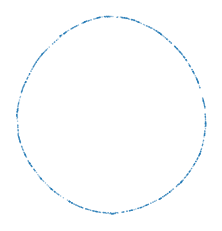

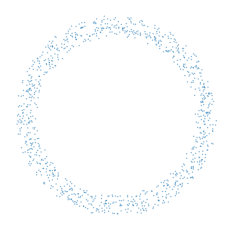

In [16]:
# plot one of the rings
for i, umapper in enumerate(umappers_multi_ring):
    # select a ring
    # randomly:
    #j = np.random.randint(n_rings[-1])
    #j = j % n_rings[i]
    # or manually
    j=0

    fig_ring_j_embd = plt.figure()
    plt.scatter(*umapper.embedding_[j*1000:(j+1)*1000].T,
                s=2,
                alpha = 0.5,
                edgecolors="none",
                linewidth=0)
    plt.gca().set_aspect("equal")
    plt.axis("off")
    fig_ring_j_embd.savefig(os.path.join(fig_path, f"toy_multi_ring_{n_rings[i]}_ring_{j}_{radius}_{sig_str}_embedding_{data_seed}_{umap_seed}.png"),
                            bbox_inches = 'tight',
                            pad_inches = 0,
                            dpi=300)


    plt.figure()
    plt.scatter(*datasets_multi_ring[i][j*1000:(j+1)*1000].T,
                s=2,
                alpha = 0.5,
                edgecolors="none",
                linewidth=0)
    plt.gca().set_aspect("equal")
    plt.axis("off")


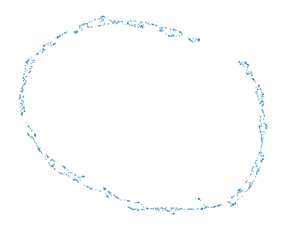

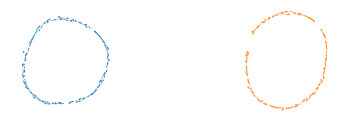

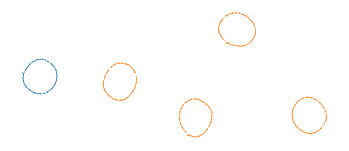

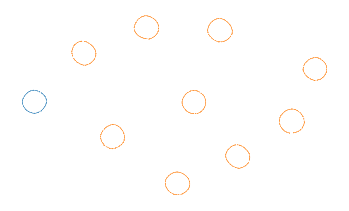

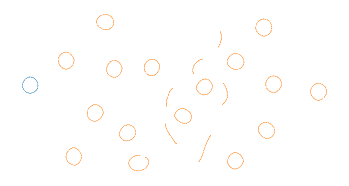

In [15]:
# plot all ring embeddings
for i, umapper in enumerate(umappers_multi_ring):
    fig_multi_ring_embd = plt.figure()
    plt.scatter(*umapper.embedding_[0:1000].T,
                s=2/(n_rings[i]),
                alpha = 0.5,
                edgecolors="none",
                linewidth=0.0)
    plt.scatter(*umapper.embedding_[1000:].T,
                s=2/(n_rings[i]),
                alpha = 0.5,
                edgecolors="none",
                linewidth=0.0)

    plt.gca().set_aspect("equal")
    plt.axis('off')
    fig_multi_ring_embd.savefig(os.path.join(fig_path, f"toy_multi_ring_{n_rings[i]}_all_rings_{radius}_{sig_str}_embedding_{data_seed}_{umap_seed}.png"),
                                bbox_inches = 'tight',
                                pad_inches = 0,
                                dpi=300)

In [57]:
# compute k-nearest neighbour radii
k = 15
knn_dists = kNN_dists(datasets_multi_ring[0], k=k)

In [58]:
knn_radii = knn_dists.cpu().numpy().max(1)

print(knn_radii.mean())
print(knn_radii.std())

0.35828559757508815
0.06617099374500683


#### Histograms



In [6]:
alpha=0.5
min_dist = 0.1
spread = 1.0
a, b= umap.umap_.find_ab_params(spread=spread, min_dist=min_dist)


In [9]:
# filter graph as done during the UMAP optimization

fil_graphs_multi_ring = []

for umapper in umappers_multi_ring:
    fil_graph_multi_ring = filter_graph(umapper.graph_, umapper.n_epochs).tocoo()
    fil_graphs_multi_ring.append(fil_graph_multi_ring)

In [10]:
# compute the historgrams

histogram_data_multi_ring = []
for i, fil_graph in enumerate(fil_graphs_multi_ring):
    hist_high, \
    hist_high_pos, \
    hist_target, \
    hist_target_pos, \
    hist_low, \
    hist_low_pos, \
    bins = hists_from_graph_embd(graph=fil_graph,
                                 embedding=umappers_multi_ring[i].embedding_,
                                 a=a,
                                 b=b)
    histogram_data_multi_ring.append([ hist_high,
                            hist_high_pos,
                            hist_target,
                            hist_target_pos,
                            hist_low,
                            hist_low_pos,
                            bins])


Historgram counts should match product of input tensor shapes, but are 400000000 and 399999992.


In [18]:
plt.rcParams.update({'font.size': 22})

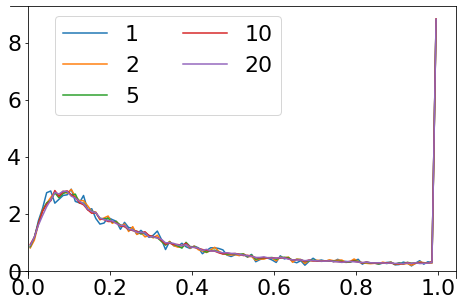

In [27]:
# plot density curves instead of histograms
plt.figure(figsize=(8,5))
for i, histogram_data_i in enumerate(histogram_data_multi_ring):
    plt.plot(bins[:-1]+0.005, len(bins) * histogram_data_i[1] / histogram_data_i[1].sum(), label=n_rings[i])
plt.legend(ncol=2, loc=(0.1,0.6))
plt.gca().spines['left'].set_position("zero")
plt.gca().spines['bottom'].set_position("zero")
plt.savefig(os.path.join(fig_path, f"toy_multi_ring_high_sim_{radius}_{sig_str}_{data_seed}_{umap_seed}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300)

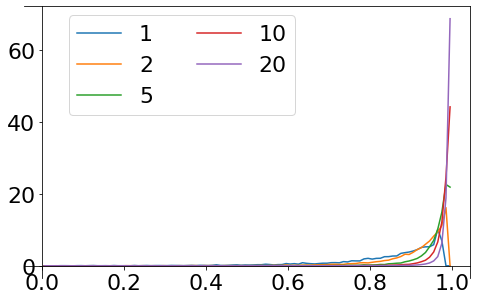

In [29]:
plt.figure(figsize=(8,5))
for i, histogram_data_i in enumerate(histogram_data_multi_ring):
    plt.plot(bins[:-1]+0.005, len(bins) * histogram_data_i[3] / histogram_data_i[3].sum(), label=n_rings[i])
plt.legend(ncol=2, loc=(0.1,0.6))
plt.gca().spines['left'].set_position("zero")
plt.gca().spines['bottom'].set_position("zero")
plt.savefig(os.path.join(fig_path, f"toy_multi_ring_target_sim_{radius}_{sig_str}_{data_seed}_{umap_seed}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300)


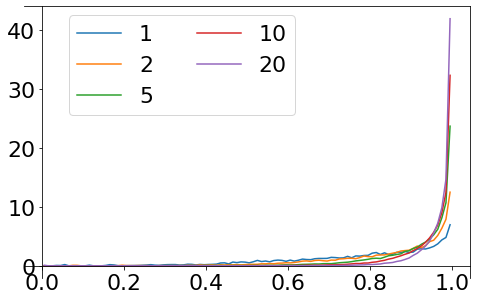

In [28]:
plt.figure(figsize=(8,5))
for i, histogram_data_i in enumerate(histogram_data_multi_ring):
    plt.plot(bins[:-1]+0.005, len(bins) * histogram_data_i[5] / histogram_data_i[5].sum(), label=n_rings[i])
plt.legend(ncol=2, loc=(0.1,0.6))
plt.gca().spines['left'].set_position("zero")
plt.gca().spines['bottom'].set_position("zero")


plt.savefig(os.path.join(fig_path, f"toy_multi_ring_low_sim_{radius}_{sig_str}_{data_seed}_{umap_seed}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300)

101